In [0]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
!pip install scorecardpy
import scorecardpy as sc
from sklearn.linear_model import LogisticRegression
!gdown "https://drive.google.com/uc?id=1HAItdPa8TP-09OLSQ-Z5z3T_UbMp5mrt"
!unzip 'Coursework 2 - Lending Club Data.zip'
df=pd.read_csv("LCFinal.csv")
df.head()

Downloading...
From: https://drive.google.com/uc?id=1HAItdPa8TP-09OLSQ-Z5z3T_UbMp5mrt
To: /content/Coursework 2 - Lending Club Data.zip
369MB [00:02, 145MB/s]
Archive:  Coursework 2 - Lending Club Data.zip
replace LCFinal.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace Variable Dictionary.docx? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (1,17,47,56,115,126,127,128,131,132,133,136,142,143,144) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Unnamed: 0,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_title,emp_length,home_ownership,annual_inc,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,...,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,leadman,10+ years,MORTGAGE,55000.0,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,190xx,PA,5.91,0.0,Aug-2003,675.0,679.0,1.0,30.0,NaN,7.0,0.0,2765.0,29.7,13.0,w,0.00,0.00,4421.723917,4421.72,...,178050.0,7746.0,2400.0,13734.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,Engineer,10+ years,MORTGAGE,65000.0,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,Business,577xx,SD,16.06,1.0,Dec-1999,715.0,719.0,4.0,6.0,NaN,22.0,0.0,21470.0,19.2,38.0,w,0.00,0.00,25679.660000,25679.66,...,314017.0,39475.0,79300.0,24667.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,truck driver,10+ years,MORTGAGE,63000.0,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,NaN,605xx,IL,10.78,0.0,Aug-2000,695.0,699.0,0.0,NaN,NaN,6.0,0.0,7869.0,56.2,18.0,w,0.00,0.00,22705.924294,22705.92,...,218418.0,18696.0,6200.0,14877.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,Information Systems Officer,10+ years,MORTGAGE,110000.0,Dec-2015,Current,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,debt_consolidation,Debt consolidation,076xx,NJ,17.06,0.0,Sep-2008,785.0,789.0,0.0,NaN,NaN,13.0,0.0,7802.0,11.6,17.0,w,15897.65,15897.65,31464.010000,31464.01,...,381215.0,52226.0,62500.0,18000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,Contract Specialist,3 years,MORTGAGE,104433.0,Dec-2015,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,major_purchase,Major purchase,174xx,PA,25.37,1.0,Jun-1998,695.0,699.0,3.0,12.0,NaN,12.0,0.0,21929.0,64.5,35.0,w,0.00,0.00,11740.500000,11740.50,...,439570.0,95768.0,20300.0,88097.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
### missing value analysis
# define a function that see percentage of missing values
def missing_values_table(df):
     # Total missing values
    mis_val = df.isnull().sum()
    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_type = df.dtypes
    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_type], axis=1)
        
     # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(columns = {0 : 'Missing Values', 1 : '% of Total Values', 2: 'type'})
        
    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[ mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1)
        
    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n" "There are " + str(mis_val_table_ren_columns.shape[0]) + " columns that have missing values.")
        
    # Return the dataframe with missing information
    return mis_val_table_ren_columns

missing_values_table(df)

Your selected dataframe has 148 columns.
There are 146 columns that have missing values.


,Missing Values,% of Total Values,type
member_id,2260701,100.0,float64
orig_projected_additional_accrued_interest,2252050,99.6,float64
hardship_dpd,2249784,99.5,float64
hardship_status,2249784,99.5,object
deferral_term,2249784,99.5,float64
...,...,...,...
out_prncp_inv,33,0.0,float64
total_pymnt,33,0.0,float64
total_pymnt_inv,33,0.0,float64
total_rec_prncp,33,0.0,float64


In [0]:
# drop cols that have over 40% missing values
missing_frac = df.isnull().mean()
drop_list = sorted(missing_frac[missing_frac > 0.40].index)
df = df.drop(drop_list,axis=1)
# drop cols that are not useful for prediction, such as dates, descriptions, ids;
# and drop those that seem duplicate
df = df.drop(["Unnamed: 0","id","funded_amnt_inv","issue_d","url","title","earliest_cr_line","out_prncp_inv","total_pymnt_inv",
              "last_pymnt_d","last_credit_pull_d"],axis=1)
# drop columns that contain too many unique values
df = df.drop(["emp_title"],axis=1)

# for modelling PD, some variables shoudln't be used because they are not available at the point of application scoring.
drop_list=["recoveries","collection_recovery_fee","hardship_flag","debt_settlement_flag","funded_amnt","total_pymnt",
           "initial_list_status","installment","out_prncp","pymnt_plan","total_rec_prncp","total_rec_int","total_rec_late_fee","last_pymnt_amnt"]
df = df.drop(drop_list,axis=1)

# drop rows that have missing values in either emp_title,emp_length,last_fico_range_high,last_fico_range_low,fico_range_high,fico_range_low because they can be very important at application scoring
drop_list=["zip_code","addr_state","emp_length","last_fico_range_high","last_fico_range_low",
           "fico_range_high","fico_range_low","annual_inc","loan_status","loan_amnt","home_ownership"]
df = df.dropna(axis=0,subset=drop_list)
# dealing with missing values. for continuous variable, fill with median. for discrete numeric(0,1,2,3...) fill with 0.
df.revol_util.fillna(value=df.revol_util.median(),inplace=True)
df.total_bc_limit.fillna(value=df.total_bc_limit.median(),inplace=True)
df.total_bal_ex_mort.fillna(value=df.total_bal_ex_mort.median(),inplace=True)
df.tot_hi_cred_lim.fillna(value=df.tot_hi_cred_lim.median(),inplace=True)
df.total_il_high_credit_limit.fillna(value=df.total_il_high_credit_limit.median(),inplace=True)
df.tot_cur_bal.fillna(value=df.tot_cur_bal.median(),inplace=True)
df.total_rev_hi_lim.fillna(value=df.total_rev_hi_lim.median(),inplace=True)
df.avg_cur_bal.fillna(value=df.avg_cur_bal.median(),inplace=True)
df.pct_tl_nvr_dlq.fillna(value=df.pct_tl_nvr_dlq.median(),inplace=True)
df.percent_bc_gt_75.fillna(value=df.percent_bc_gt_75.median(),inplace=True)
df.bc_open_to_buy.fillna(value=df.bc_open_to_buy.median(),inplace=True)
df.bc_util.fillna(value=df.bc_util.median(),inplace=True)
df.total_bal_il.fillna(value=df.total_bal_il.median(),inplace=True)
df.max_bal_bc.fillna(value=df.max_bal_bc.median(),inplace=True)
df.total_cu_tl.fillna(value=df.total_cu_tl.median(),inplace=True)
df.all_util.fillna(value=df.all_util.median(),inplace=True)

# Then assume the rest of the missing values mean no accounts or trades opened, fill na in these cols with 0.
df = df.fillna(value=0,axis=1)

In [0]:
# check again for missing values
missing_values_table(df)
print(df.shape)

Your selected dataframe has 76 columns.
There are 0 columns that have missing values.
(2113756, 76)


In [0]:
### transform or add new predictors
# truncate zip_code and leave only first digit
df.zip_code = df.zip_code.apply(lambda x:x[:1])

# combine fico score high and low into one. because they will have high correlations.
df = df.assign(fico = (df.fico_range_high+df.fico_range_low)/2)
df = df.assign(last_fico = (df.last_fico_range_high+df.last_fico_range_low)/2)
df=df.drop(["fico_range_high","fico_range_low","last_fico_range_high","last_fico_range_low"],axis=1)

In [1]:
df = df.drop(df[(df.loan_status!="Fully Paid") & (df.loan_status!="Charged Off")].index)
print(df.shape)
# convert target variable to 0 and 1.
df.loc[df.loan_status == "Fully Paid","loan_status"] = 0
df.loc[df.loan_status == "Charged Off","loan_status"] = 1

NameError: ignored

In [0]:
### correlation filter
cor = df.corr(method="spearman")
sns.heatmap(cor, xticklabels=cor.columns,yticklabels=cor.columns)

KeyboardInterrupt: ignored

In [0]:
# variable selection criteria: 
# for a group of correlated variables(corr>0.5),keep one that has highest correlation with loan_status, drop the rest

cols_to_drop=[]
# keep num_rev_tl_bal_gt_0 
cols_to_drop = np.append(cols_to_drop,["num_bc_sats","open_acc","total_acc","bc_open_to_buy","num_op_rev_tl",
                                       "num_actv_rev_tl","num_actv_bc_tl","num_rev_accts","num_sats"])
# keep delinq_amnt
cols_to_drop = np.append(cols_to_drop,["acc_now_delinq","num_tl_30dpd"])

# keep avg_cur_bal 0.07 ,total_bc_limit,mort_acc,tot_high_cred_lim
cols_to_drop = np.append(cols_to_drop,["total_il_high_credit_limit","total_bal_il","total_bal_ex_mort","open_act_il","num_il_tl",
                                       "tot_cur_bal","num_bc_sats","num_bc_tl"])
# pub_rec,mths_since_last_record highly correlated. keep pub_rec.
cols_to_drop = np.append(cols_to_drop,["pub_rec_bankruptcies"])

# variables that describe number of accounts opened, only keep  acc_open_past_24mths 0.1
cols_to_drop = np.append(cols_to_drop,["open_acc_6m","open_il_12m","open_il_24m","open_rv_12m","open_rv_24m","num_tl_op_past_12m","mo_sin_rcnt_tl"])

# keep  0.66 ,mo_sin_old_rev_tl_op, 
cols_to_drop = np.append(cols_to_drop,["bc_util","revol_util"])

# revol_bal and max_bal_bc. keep max_bal_bc 0.02
cols_to_drop = np.append(cols_to_drop,["revol_bal"])

# total_bc_limit 0.07,max_bal_bc 0.02. keep 
cols_to_drop = np.append(cols_to_drop,["max_bal_bc"])
# num_tl_op_past_12m acc_open_past_24mths.
cols_to_drop = np.append(cols_to_drop,["mo_sin_rcnt_rev_tl_op"])
# keep num_accts_ever_120_pd                  0.02  
cols_to_drop = np.append(cols_to_drop,["pct_tl_nvr_dlq"])
df= df.drop(["inq_fi","tot_hi_cred_lim"],axis=1)
df = df.drop(cols_to_drop,axis=1)

In [0]:
df.columns

Index(['loan_amnt', 'term', 'int_rate', 'emp_length', 'home_ownership',
       'annual_inc', 'loan_status', 'purpose', 'zip_code', 'addr_state', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'pub_rec',
       'collections_12_mths_ex_med', 'application_type', 'tot_coll_amt',
       'all_util', 'total_rev_hi_lim', 'total_cu_tl', 'inq_last_12m',
       'acc_open_past_24mths', 'avg_cur_bal', 'chargeoff_within_12_mths',
       'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mort_acc',
       'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_rev_tl_bal_gt_0', 'num_tl_120dpd_2m',
       'num_tl_90g_dpd_24m', 'percent_bc_gt_75', 'tax_liens', 'total_bc_limit',
       'disbursement_method', 'fico', 'last_fico'],
      dtype='object')

In [0]:
cor = df.corr(method="spearman")
sns.heatmap(cor, xticklabels=cor.columns,yticklabels=cor.columns)

KeyboardInterrupt: ignored

In [0]:
## dealing with outliers
outlier_cols = ["dti","avg_cur_bal","annual_inc","mort_acc","loan_amnt","total_bc_limit"]
for col in outlier_cols:
  d = df[col]
  q1=np.percentile(d,25,interpolation="midpoint")
  q3=np.percentile(d,75,interpolation="midpoint")
  iqr=q3-q1
  lower = np.median(d) - 3*iqr/(2*0.6745)
  upper = np.median(d) + 3*iqr/(2*0.6745)
  df = df.loc[(d<=upper)]

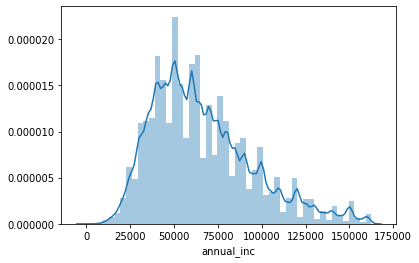

In [0]:
sns.distplot(df.annual_inc)

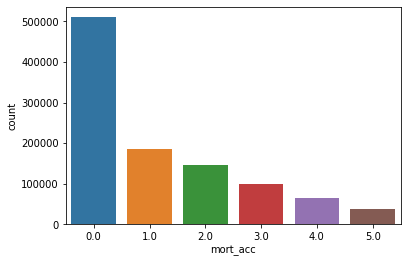

In [0]:
sns.countplot(df.mort_acc)

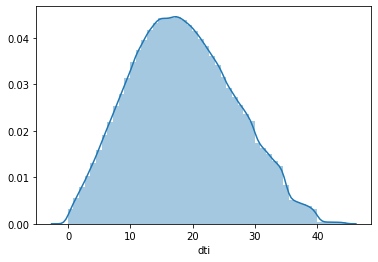

In [0]:
sns.distplot(df.dti)

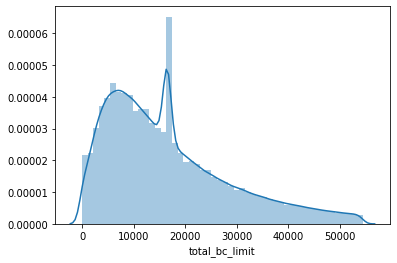

In [0]:
sns.distplot(df.total_bc_limit)

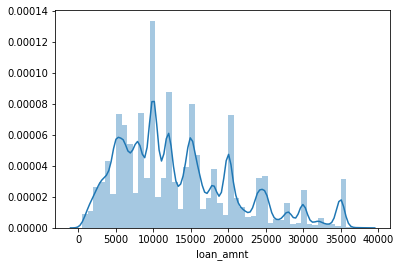

In [0]:
sns.distplot(df.loan_amnt)

In [0]:
# now df is ready to use woe to go for modelling pd
# train test split
from sklearn.model_selection import train_test_split
train,test = train_test_split(df,train_size=0.7,random_state=0)
print(train.shape)
print(test.shape)
train.head()

(728797, 40)
(312342, 40)


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,loan_status,purpose,zip_code,addr_state,dti,delinq_2yrs,inq_last_6mths,pub_rec,collections_12_mths_ex_med,application_type,tot_coll_amt,all_util,total_rev_hi_lim,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_rev_tl_bal_gt_0,num_tl_120dpd_2m,num_tl_90g_dpd_24m,percent_bc_gt_75,tax_liens,total_bc_limit,disbursement_method,fico,last_fico
330549,1400.0,36 months,17.86,5 years,RENT,29500.0,0,other,2,NC,19.28,0.0,0.0,0.0,0.0,Individual,0.0,58.0,12800.0,0.0,0.0,3.0,4127.0,0.0,0.0,144.0,142.0,0.0,6.0,0.0,0.0,4.0,0.0,0.0,100.0,0.0,8500.0,Cash,682.0,637.0
1307040,7925.0,36 months,16.59,4 years,MORTGAGE,42500.0,0,debt_consolidation,3,GA,12.12,0.0,2.0,1.0,0.0,Individual,0.0,58.0,10300.0,0.0,0.0,5.0,1465.0,0.0,0.0,129.0,256.0,1.0,3.0,3.0,4.0,3.0,0.0,0.0,25.0,0.0,7000.0,Cash,667.0,752.0
1214015,15975.0,36 months,24.99,10+ years,OWN,53453.4,0,debt_consolidation,8,UT,23.91,0.0,4.0,1.0,0.0,Individual,0.0,58.0,15700.0,0.0,0.0,3.0,2861.0,0.0,0.0,75.0,440.0,0.0,103.0,2.0,0.0,9.0,0.0,0.0,100.0,1.0,6100.0,Cash,662.0,557.0
2058564,35000.0,60 months,19.03,6 years,MORTGAGE,95000.0,0,debt_consolidation,7,TX,15.95,0.0,2.0,0.0,0.0,Individual,0.0,50.0,64200.0,1.0,4.0,13.0,15078.0,0.0,0.0,134.0,81.0,2.0,3.0,3.0,0.0,13.0,0.0,0.0,33.3,0.0,50500.0,Cash,677.0,652.0
210720,8275.0,36 months,13.99,10+ years,MORTGAGE,59000.0,0,debt_consolidation,3,FL,26.57,0.0,1.0,0.0,0.0,Individual,65.0,58.0,9050.0,0.0,0.0,6.0,27735.0,0.0,0.0,170.0,240.0,3.0,9.0,5.0,0.0,4.0,0.0,0.0,0.0,0.0,1200.0,Cash,682.0,692.0


In [0]:
bins = sc.woebin(train, y = 'loan_status', 
                 min_perc_fine_bin=0.05, # How many bins to cut initially into
                 min_perc_coarse_bin=0.05,  # Minimum percentage per final bin
                 stop_limit=0.1, # Minimum information value 
                 max_num_bin=8, # Maximum number of bins
                 method='tree')
train_woe = sc.woebin_ply(train,bins)
test_woe = sc.woebin_ply(test,bins)
train_woe.head()

[INFO] creating woe binning ...
>>> There are 1 variables have too many unique non-numberic values, which might cause the binning process slow. Please double check the following variables: 
addr_state
>>> Continue the binning process?
1: yes 
2: no
Selection: 1
Binning on 728797 rows and 40 columns in 00:02:33
[INFO] converting into woe values ...
Woe transformating on 728797 rows and 39 columns in 00:01:31
[INFO] converting into woe values ...
Woe transformating on 312342 rows and 39 columns in 00:00:41


,loan_status,chargeoff_within_12_mths_woe,emp_length_woe,percent_bc_gt_75_woe,last_fico_woe,addr_state_woe,loan_amnt_woe,term_woe,pub_rec_woe,avg_cur_bal_woe,num_rev_tl_bal_gt_0_woe,tot_coll_amt_woe,num_tl_120dpd_2m_woe,total_bc_limit_woe,inq_last_6mths_woe,total_rev_hi_lim_woe,mo_sin_old_rev_tl_op_woe,mths_since_recent_inq_woe,acc_open_past_24mths_woe,num_tl_90g_dpd_24m_woe,annual_inc_woe,collections_12_mths_ex_med_woe,disbursement_method_woe,application_type_woe,purpose_woe,dti_woe,fico_woe,home_ownership_woe,int_rate_woe,inq_last_12m_woe,delinq_amnt_woe,delinq_2yrs_woe,mort_acc_woe,tax_liens_woe,mths_since_recent_bc_woe,num_accts_ever_120_pd_woe,all_util_woe,mo_sin_old_il_acct_woe,total_cu_tl_woe,zip_code_woe
0,0,0.0,-0.017499,-0.235197,2.342824,-0.000381,-0.311339,-0.284086,0.0,-0.296406,-0.050295,0.0,0.0,0.143684,0.095356,0.133821,0.085561,0.024159,-0.082076,0.0,0.024271,0.0,0.0,0.0,0.077087,-0.292384,0.271778,-0.151100,0.196129,0.362262,0.0,-0.011445,-0.003868,0.0,0.094422,0.086666,-0.253577,-0.019822,-0.013489,0.098830
2,0,0.0,-0.017499,-0.053224,-3.761063,-0.127947,0.232437,0.699796,0.0,-0.296406,-0.196667,0.0,0.0,0.143684,-0.135005,0.065939,-0.045104,-0.125805,0.135341,0.0,0.024271,0.0,0.0,0.0,-0.111956,-0.292384,0.061104,-0.151100,-0.645497,0.072827,0.0,-0.011445,-0.222832,0.0,-0.334338,-0.010331,0.308256,-0.019822,0.080209,-0.053402
5,0,0.0,-0.017499,0.201777,-3.761063,-0.127947,0.024325,-0.284086,0.0,0.132028,-0.196667,0.0,0.0,0.143684,-0.135005,0.065939,0.334658,-0.121216,-0.420510,0.0,0.098590,0.0,0.0,0.0,0.077087,-0.292384,0.061104,0.135534,0.196129,-0.094789,0.0,-0.011445,0.109055,0.0,-0.164239,-0.010331,0.308256,-0.019822,-0.013489,0.033935
7,0,0.0,-0.017499,-0.235197,-2.036713,-0.299910,0.232437,-0.284086,0.0,-0.148683,-0.196667,0.0,0.0,0.049087,-0.135005,0.065939,0.334658,0.024159,-0.082076,0.0,-0.044823,0.0,0.0,0.0,-0.111956,-0.080458,-0.130314,-0.151100,-0.645497,0.198251,0.0,-0.011445,-0.222832,0.0,-0.164239,-0.010331,-0.075135,-0.019822,-0.013489,-0.004507
8,0,0.0,-0.017499,-0.053224,-3.761063,-0.000381,0.024325,-0.284086,0.0,0.132028,0.132642,0.0,0.0,-0.107807,0.095356,-0.080348,0.085561,0.275614,0.135341,0.0,-0.044823,0.0,0.0,0.0,-0.208534,-0.292384,0.061104,0.135534,-1.426451,0.072827,0.0,-0.011445,-0.003868,0.0,0.094422,-0.010331,-0.075135,-0.019822,-0.013489,0.098830


/usr/local/lib/python3.6/dist-packages/scorecardpy/woebin.py:1197: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax1 = plt.subplots()


{'acc_open_past_24mths': <Figure size 432x288 with 2 Axes>,
 'addr_state': <Figure size 432x288 with 2 Axes>,
 'all_util': <Figure size 432x288 with 2 Axes>,
 'annual_inc': <Figure size 432x288 with 2 Axes>,
 'application_type': <Figure size 432x288 with 2 Axes>,
 'avg_cur_bal': <Figure size 432x288 with 2 Axes>,
 'chargeoff_within_12_mths': <Figure size 432x288 with 2 Axes>,
 'collections_12_mths_ex_med': <Figure size 432x288 with 2 Axes>,
 'delinq_2yrs': <Figure size 432x288 with 2 Axes>,
 'delinq_amnt': <Figure size 432x288 with 2 Axes>,
 'disbursement_method': <Figure size 432x288 with 2 Axes>,
 'dti': <Figure size 432x288 with 2 Axes>,
 'emp_length': <Figure size 432x288 with 2 Axes>,
 'fico': <Figure size 432x288 with 2 Axes>,
 'home_ownership': <Figure size 432x288 with 2 Axes>,
 'inq_last_12m': <Figure size 432x288 with 2 Axes>,
 'inq_last_6mths': <Figure size 432x288 with 2 Axes>,
 'int_rate': <Figure size 432x288 with 2 Axes>,
 'last_fico': <Figure size 432x288 with 2 Axes>,


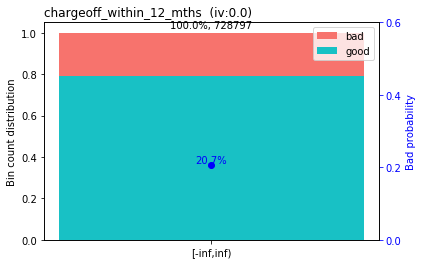

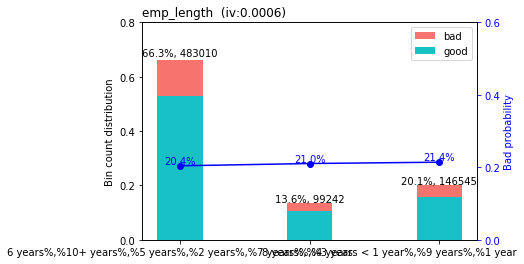

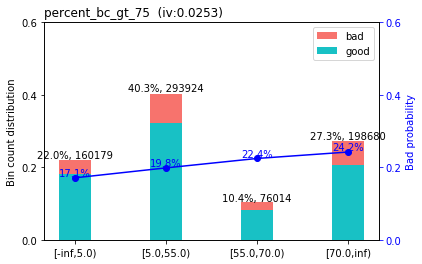

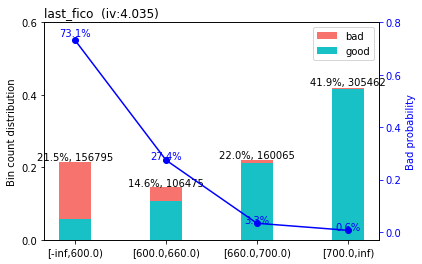

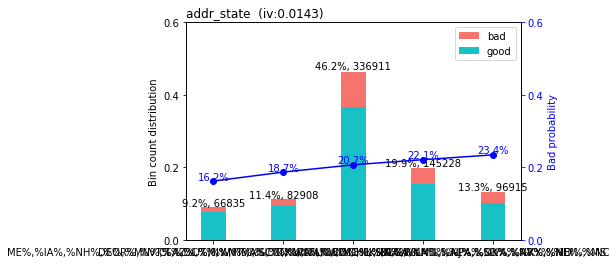

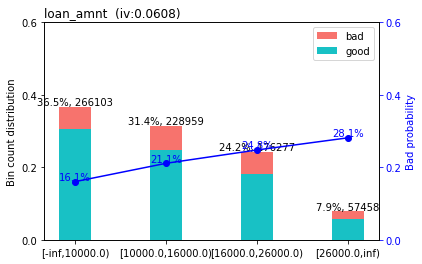

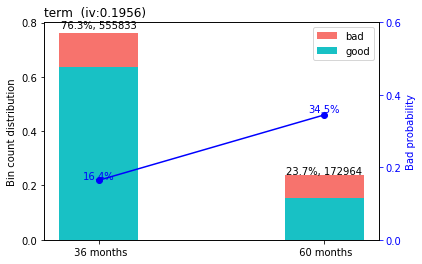

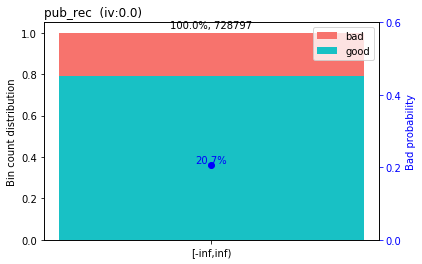

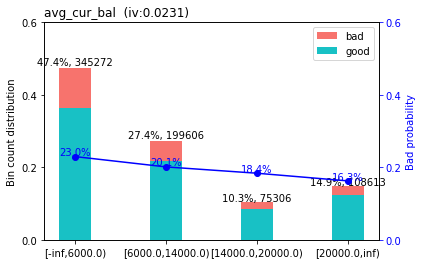

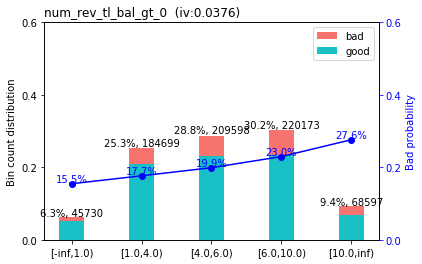

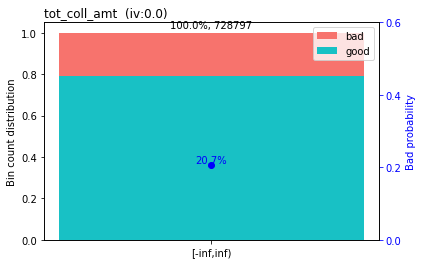

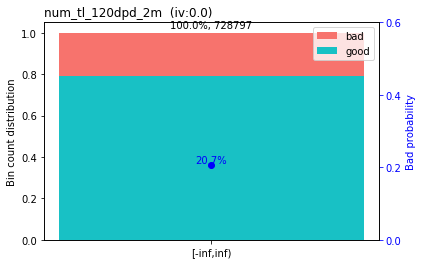

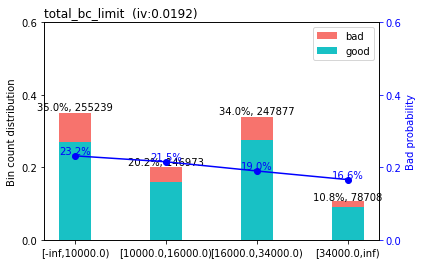

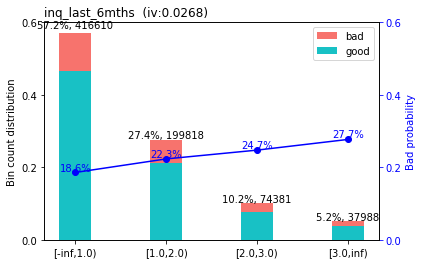

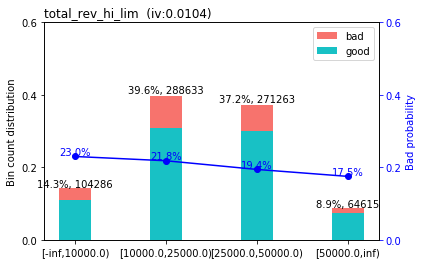

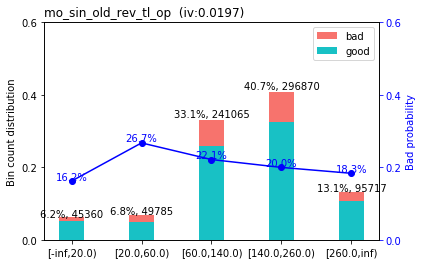

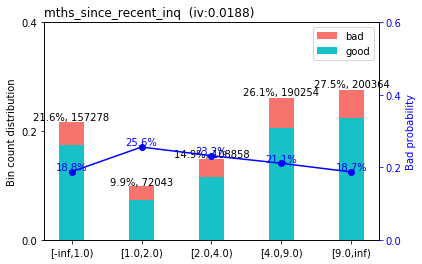

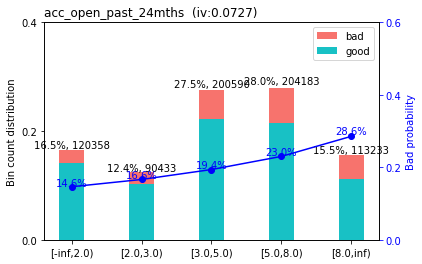

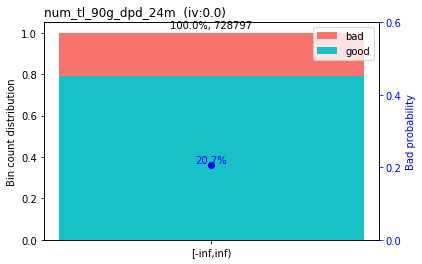

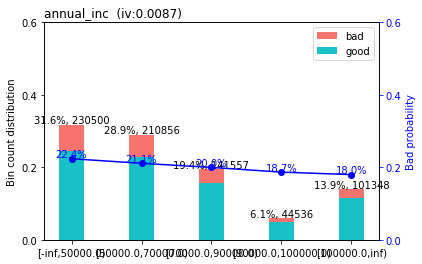

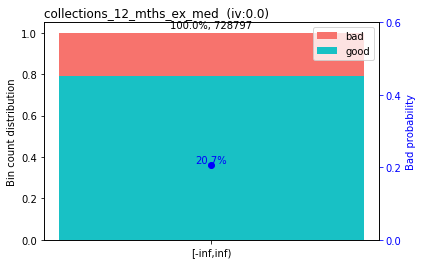

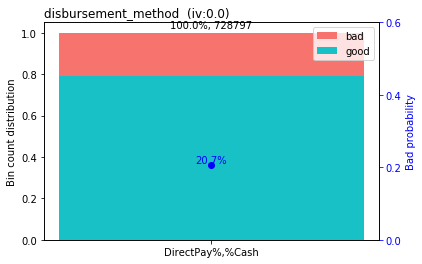

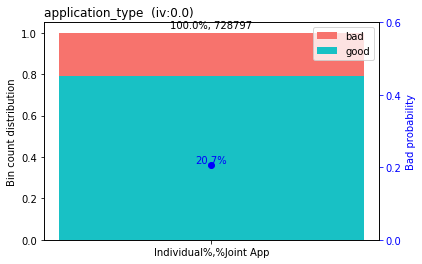

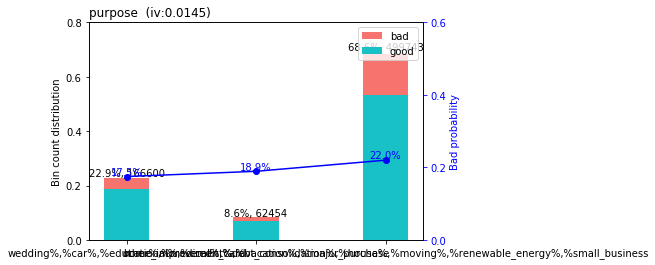

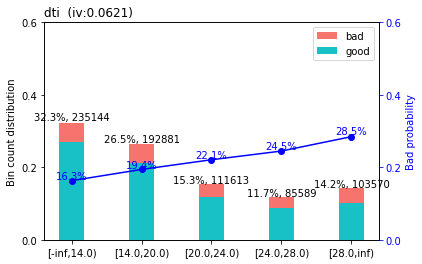

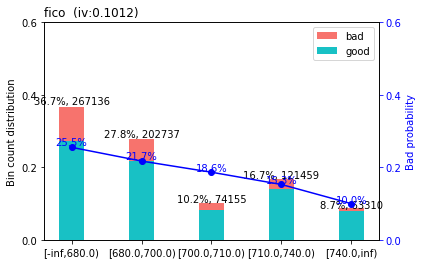

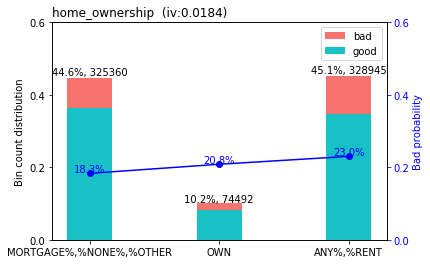

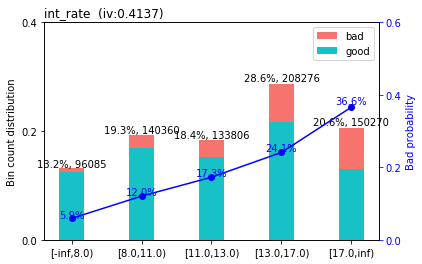

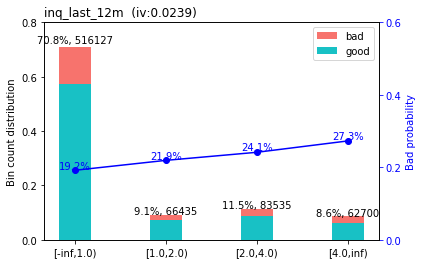

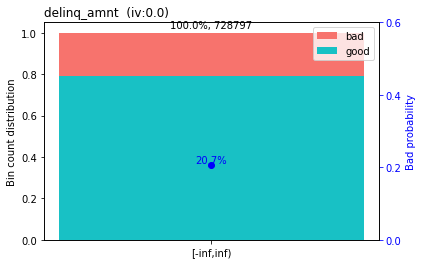

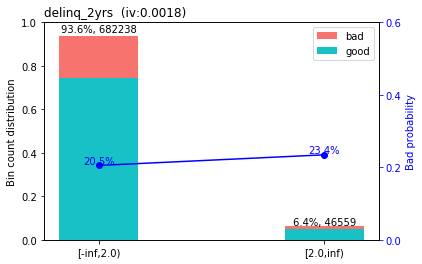

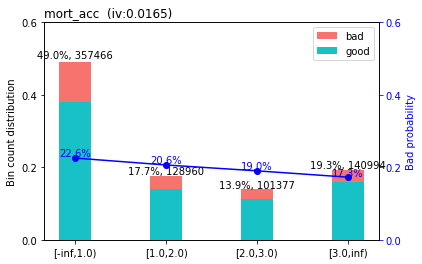

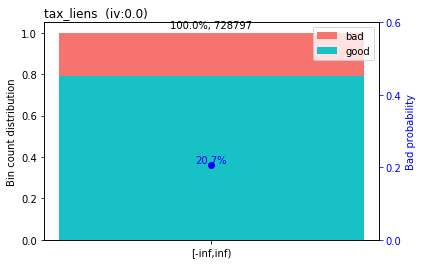

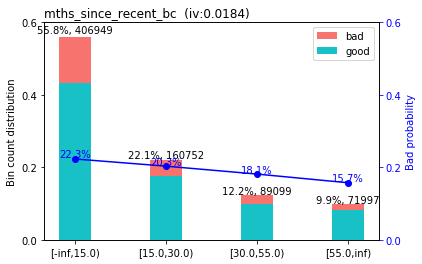

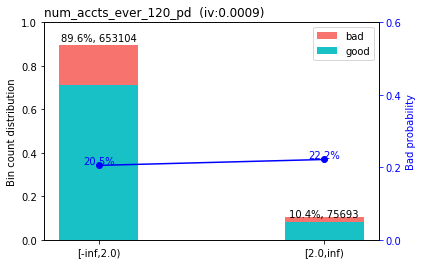

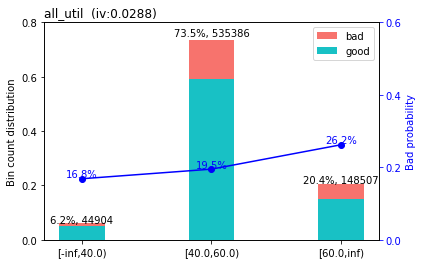

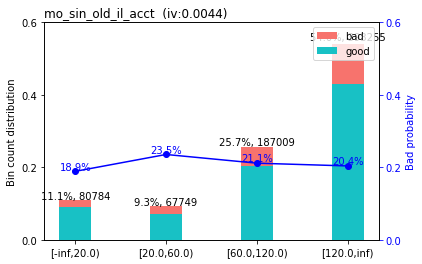

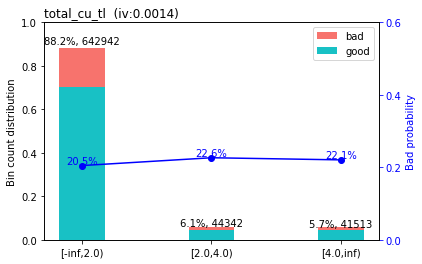

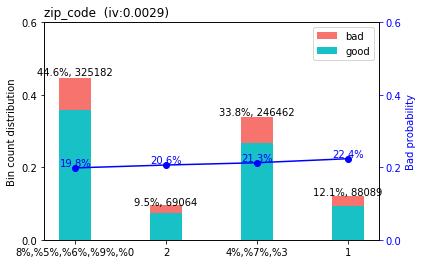

In [0]:
sc.woebin_plot(bins)

In [0]:
sc.iv(train_woe,"loan_status")


,variable,info_value
26,last_fico_woe,4.034973
35,int_rate_woe,0.413657
10,term_woe,0.195582
17,fico_woe,0.101205
4,acc_open_past_24mths_woe,0.072719
21,dti_woe,0.062115
12,loan_amnt_woe,0.060789
0,num_rev_tl_bal_gt_0_woe,0.037641
5,all_util_woe,0.028827
19,inq_last_6mths_woe,0.026834


In [0]:
accepted_cols=["last_fico_woe","fico_woe","int_rate_woe","term_woe","acc_open_past_24mths_woe","dti_woe","loan_amnt_woe","loan_status"]
train_woe = train_woe.loc[:,accepted_cols]
test_woe = test_woe.loc[:,accepted_cols]
train_woe.head()

,last_fico_woe,fico_woe,int_rate_woe,term_woe,acc_open_past_24mths_woe,dti_woe,loan_amnt_woe,loan_status
0,2.342824,0.271778,0.196129,-0.284086,-0.082076,-0.292384,-0.311339,0
2,-3.761063,0.061104,-0.645497,0.699796,0.135341,-0.292384,0.232437,0
5,-3.761063,0.061104,0.196129,-0.284086,-0.420510,-0.292384,0.024325,0
7,-2.036713,-0.130314,-0.645497,-0.284086,-0.082076,-0.080458,0.232437,0
8,-3.761063,0.061104,-1.426451,-0.284086,0.135341,-0.292384,0.024325,0


In [0]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(penalty='l1', # Type of penalization l1 = lasso, l2 = ridge
                                     tol=0.0001, # Tolerance for parameters
                                     C=1, # Penalty constant, see below
                                     fit_intercept=True, # Use constant?
                                     class_weight='balanced', # Weights, see below
                                     random_state=251086706, # Random seed
                                     max_iter=10000, # Maximum iterations
                                     verbose=1, # Show process. 1 is yes.
                                     solver = 'saga',
                                     warm_start=False # Train anew or start from previous weights. For repeated training. 
                                    )
logreg.fit(X=train_woe.iloc[:,:-1],y=train_woe.loan_status)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 17 epochs took 10 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   10.2s finished


LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=251086706, solver='saga', tol=0.0001, verbose=1,
                   warm_start=False)

In [0]:
coef_df = pd.concat([pd.DataFrame({'column': train_woe.columns[:-1]}), 
                    pd.DataFrame(np.transpose(logreg.coef_))],
                    axis = 1)
coef_df

,column,0
0,last_fico_woe,1.020936
1,fico_woe,-0.538541
2,int_rate_woe,0.232060
3,term_woe,0.746419
4,acc_open_past_24mths_woe,0.123600
5,dti_woe,0.660914
6,loan_amnt_woe,1.037251


In [0]:
logreg.intercept_

array([0.00372038])

In [0]:
pred_class_test = logreg.predict(test_woe.iloc[:,:-1])
probs_test = logreg.predict_proba(test_woe.iloc[:,:-1])
print(probs_test[0:10], pred_class_test[0:10])

[[0.90864868 0.09135132]
 [0.9834482  0.0165518 ]
 [0.04652032 0.95347968]
 [0.62296317 0.37703683]
 [0.93777269 0.06222731]
 [0.93146125 0.06853875]
 [0.9454621  0.0545379 ]
 [0.05662755 0.94337245]
 [0.91272289 0.08727711]
 [0.0277776  0.9722224 ]] [0 0 1 0 0 0 0 1 0 1]


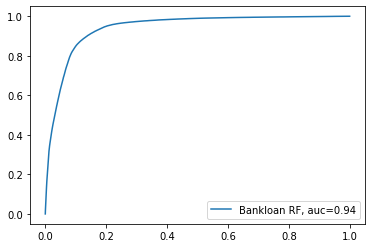

In [0]:
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
# Calculate the ROC curve points
fpr, tpr, thresholds = roc_curve(test_woe.loan_status, probs_test[:,1])
# Save the AUC in a variable to display it. Round it first
auc = np.round(roc_auc_score(y_true = test_woe.loan_status, y_score = probs_test[:,1]),decimals = 3)
# Create and show the plot
plt.plot(fpr,tpr,label="Bankloan RF, auc="+str(auc))
plt.legend(loc=4)
plt.show()

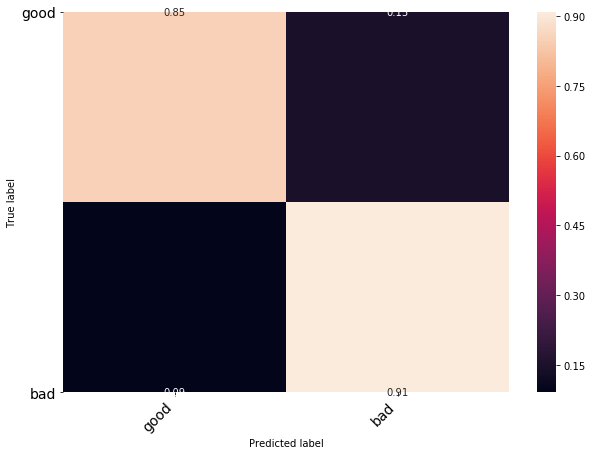

In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix_rf=confusion_matrix(y_true = test_woe.loan_status, y_pred = pred_class_test)
# Turn matrix to percentages
confusion_matrix_rf = confusion_matrix_rf.astype('float') / confusion_matrix_rf.sum(axis=1)[:, np.newaxis]

# Turn to dataframe
df_cm = pd.DataFrame(confusion_matrix_rf, index=['good', 'bad'], columns=['good', 'bad'], )

# Parameters of the image
figsize = (10,7)
fontsize=14

# Create image
fig = plt.figure(figsize=figsize)
heatmap = sns.heatmap(df_cm, annot=True, fmt='.2f')

# Make it nicer
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45,ha='right', fontsize=fontsize)

# Add labels
plt.ylabel('True label')
plt.xlabel('Predicted label')

# Plot!
plt.show()

In [0]:
# construct scorecard
scrd = sc.scorecard(bins, logreg, 
             train_woe.columns[:-1], # The column names in the trained LR
             points0=600, # Base points
             odds0=0.01, # Base odds
             pdo=50) # PDO 
scrd

{'acc_open_past_24mths':                 variable         bin  points
 57  acc_open_past_24mths  [-inf,2.0)     4.0
 58  acc_open_past_24mths   [2.0,3.0)     2.0
 59  acc_open_past_24mths   [3.0,5.0)     1.0
 60  acc_open_past_24mths   [5.0,8.0)    -1.0
 61  acc_open_past_24mths   [8.0,inf)    -4.0,
 'basepoints':      variable  bin  points
 0  basepoints  NaN   268.0,
 'dti':    variable          bin  points
 74      dti  [-inf,14.0)    14.0
 75      dti  [14.0,20.0)     4.0
 76      dti  [20.0,24.0)    -4.0
 77      dti  [24.0,28.0)   -10.0
 78      dti   [28.0,inf)   -20.0,
 'fico':    variable            bin  points
 79     fico   [-inf,680.0)    11.0
 80     fico  [680.0,700.0)     2.0
 81     fico  [700.0,710.0)    -5.0
 82     fico  [710.0,740.0)   -14.0
 83     fico    [740.0,inf)   -33.0,
 'int_rate':     variable          bin  points
 87  int_rate   [-inf,8.0)    24.0
 88  int_rate   [8.0,11.0)    11.0
 89  int_rate  [11.0,13.0)     4.0
 90  int_rate  [13.0,17.0)    -3.0
 91 

In [0]:
# apply scorecard to trainset
train_score = sc.scorecard_ply(train,scrd,print_step=0)
train_score.describe()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:576: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


,score
count,728797.000000
mean,382.181624
std,187.859103
min,-43.000000
25%,214.000000
50%,449.000000
75%,552.000000
max,636.000000
